# Check predictions on public test dataset

Compute 'recall' for each class 'recall':
- public test dataset 
- using finetunned models
    - ~~VGG16 (224x224)~~
        - ~~`test_acc=0.472 | test_f170=0.067`~~
    - InceptionResNetV2 (299x299) + TTA 
        - `test_acc=0.714 | test_f170=0.33`
    - InceptionResNetV2 (451x451) + TTA
        - `test_acc=0.776 | test_f170=0.467`
    - InceptionResNetV2 (451x451) + 2 phase training (75) + TTA
        - `test_acc=0.772 | test_f170=0.454`

In [1]:
import os 
import sys
import numpy as np
import cv2

sys.path.append("../submissions/")
sys.path.append("../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [3]:
from rampwf.workflows.image_classifier import _chunk_iterator
n_classes = 403
class_names = [str(i) for i in range(n_classes)]

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns

In [5]:
from problem import get_cv, Predictions, score_types, get_test_data

In [6]:
import imp
from problem import workflow
workflow.n_jobs = 10
workflow.chunk_size = 256
workflow.test_batch_size = 128

def compute_class_recall(submission, logs_path, n_test_samples=None):
    
    assert os.path.exists(logs_path)
    
    # Import transform, transform_test, BatchClassifier, load_pretrained_model
    module_path = os.path.join("..", "submissions", submission)
    submitted_image_preprocessor_file = os.path.join(module_path, "image_preprocessor.py")
    image_preprocessor = imp.load_source('image_preprocessor', submitted_image_preprocessor_file)
    transform = image_preprocessor.transform
    transform_test = image_preprocessor.transform_test

    submitted_batch_classifier_file = os.path.join(module_path, "batch_classifier.py")
    batch_classifier = imp.load_source('batch_classifier', submitted_batch_classifier_file)
    builder = batch_classifier.BatchClassifier()
    load_pretrained_model = batch_classifier.load_pretrained_model

    load_pretrained_model(builder.model, logs_path=logs_path)
    
    trained_model = transform, transform_test, builder
    folder_X_array, y_true_labels = get_test_data(path="..")
    
    if n_test_samples is not None:
        folder_X_array = (folder_X_array[0], folder_X_array[1][:n_samples])
        y_true_labels = y_true_labels[:n_samples]        
    
    
    y_proba = workflow.test_submission(trained_model, folder_X_array)
    y_pred_labels = np.argmax(y_proba, axis=1)
    
    res = np.zeros((n_classes, 2), dtype=np.int)
    
    for y_true, y_pred in zip(y_true_labels, y_pred_labels):
        res[y_true, 1] += 1
        if y_true == y_pred:
            res[y_true, 0] += 1
            
    class_recalls = res[:, 0] / (res[:, 1] + 1e-7)
    return class_recalls

In [7]:
path = '/home/working_directory/ml/ramp-kits/pollenating_insects_3/'

def get_logs_path(log_name):
    return os.path.join(path, log_name)


submissions = [
    ('keras_inceptionResNetV2_finetunning_imbalanced2', 
     get_logs_path('logs_2017-10-05-00-27')), 
    ('keras_inceptionResNetV2_finetunning_imbalanced3c4', 
     get_logs_path('logs_inceptionResNetV2_finetunning_imbalanced3c4_2017-10-07-08-51')), 
    ('keras_inceptionResNetV2_finetunning_imbalanced4c', 
     get_logs_path('logs_inceptionResNetV2_finetunning_imbalanced4c_20171010_1125')),
]


Load best loss weights:  /home/working_directory/ml/ramp-kits/pollenating_insects_3/logs_2017-10-05-00-27/weights/InceptionResNetV2_best_val_loss.h5
Load best loss weights:  /home/working_directory/ml/ramp-kits/pollenating_insects_3/logs_inceptionResNetV2_finetunning_imbalanced3c4_2017-10-07-08-51/weights/InceptionResNetV2_best_val_loss.h5
Load best loss weights:  /home/working_directory/ml/ramp-kits/pollenating_insects_3/logs_inceptionResNetV2_finetunning_imbalanced4c_20171010_1125/weights/InceptionResNetV2_best_val_loss.h5


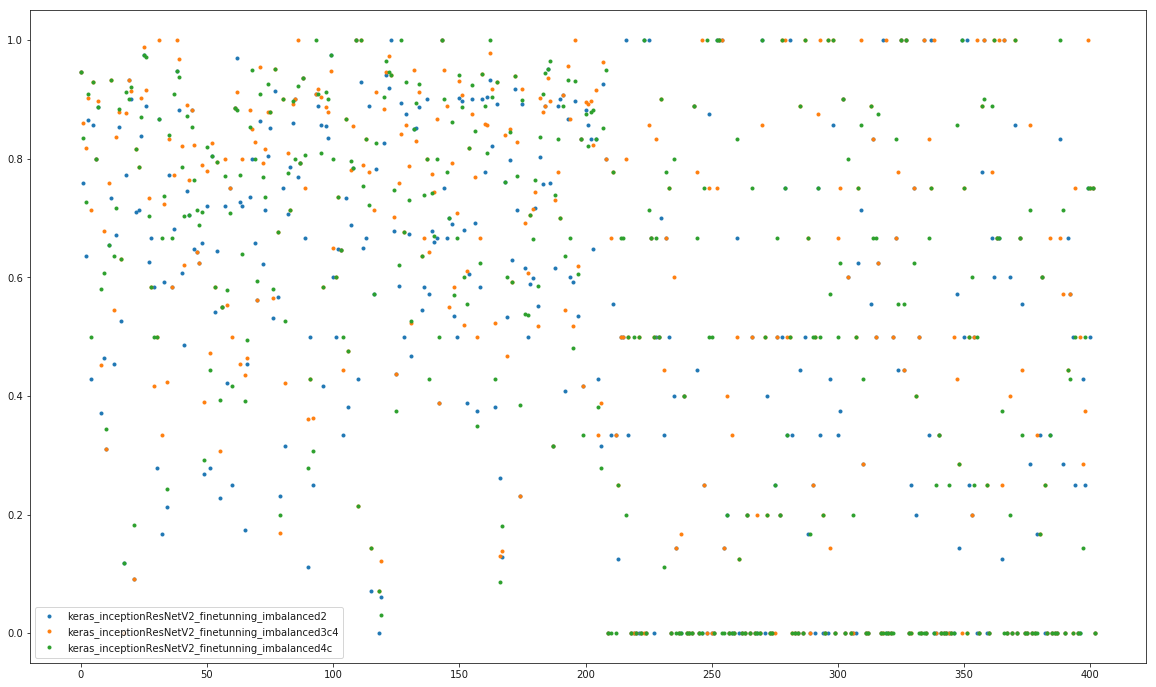

In [57]:
n_samples = None
plt.figure(figsize=(20, 12))
class_recalls_list = []
for submission, logs_path in submissions:
    class_recalls = compute_class_recall(submission, logs_path, n_test_samples=n_samples)
    plt.plot(class_recalls, '.', label=submission)
    class_recalls_list.append((submission, class_recalls))
plt.legend()

In [103]:
import pickle

with open("test_class_recalls_list.pkl", 'wb') as w:
    pickle.dump(class_recalls_list, w, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
import pickle

with open("test_class_recalls_list.pkl", 'rb') as r:
    class_recalls_list = pickle.load(r)

In [13]:
import pandas as pd

INPUT_PATH = '../data'
TRAIN_TEST_DATA = os.path.join(INPUT_PATH, 'imgs')
TRAIN_CSV_PATH = os.path.join(INPUT_PATH, 'train.csv')
TEST_CSV_PATH = os.path.join(INPUT_PATH, 'test.csv')

CLASS_CODES_DF = pd.read_csv(os.path.join(INPUT_PATH, 'class_codes.csv'))
TRAIN_CSV_DF = pd.read_csv(TRAIN_CSV_PATH)
TEST_CSV_DF = pd.read_csv(TEST_CSV_PATH)

In [28]:
class_count = np.histogram(TEST_CSV_DF['class'], bins=403)[0]
class_count = class_count * 1.0 / np.max(class_count)

In [31]:
from sklearn.utils import class_weight

In [33]:
class_weights = class_weight.compute_class_weight('balanced', list(range(403)), TRAIN_CSV_DF['class'].values)

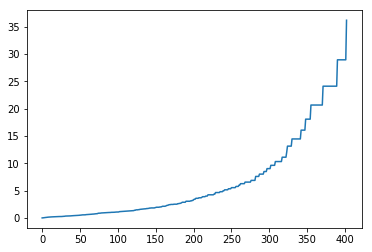

In [34]:
plt.plot(sorted(class_weights))

In [36]:
np.min(class_weights), np.argmin(class_weights) 

(0.029700833492396769, 202)

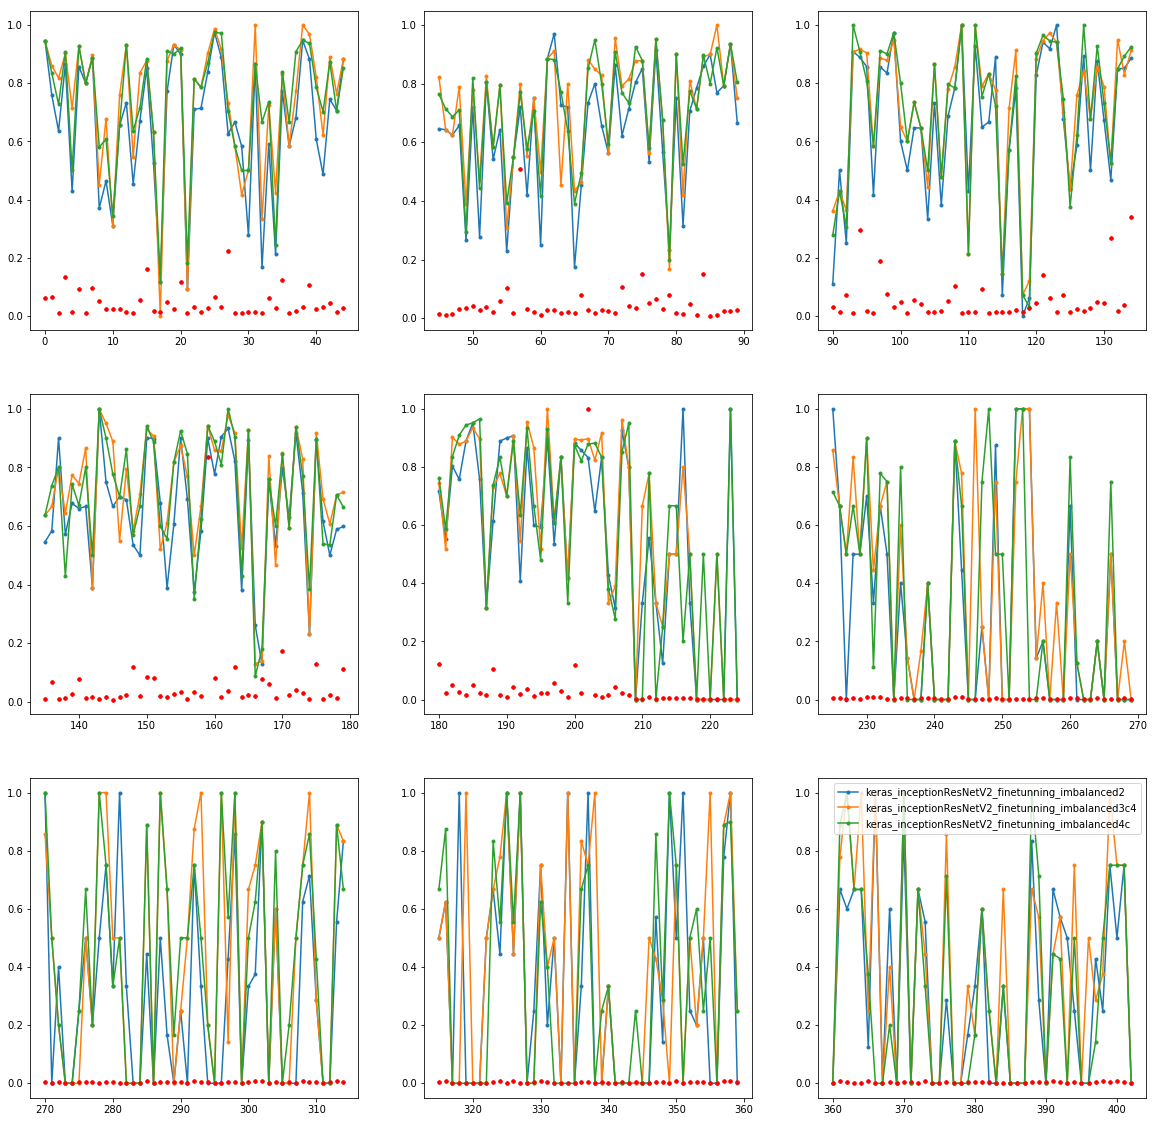

In [30]:
n = 9
ll = int(np.ceil(403 * 1.0 / n))
plt.figure(figsize=(20, 20))
for i in range(n):
    plt.subplot(3, n/3, i + 1)
    istart = i * ll
    iend = (i + 1) * ll    
    for label, class_recalls in class_recalls_list:
        iend = min(len(class_recalls), iend)
        plt.plot(list(range(istart, iend)), class_recalls[istart:iend], '.-', label=label)
        plt.plot(list(range(istart, iend)), class_count[istart:iend], 'r.')
plt.legend()

## InceptionResNetV2 model

- Image size (299x299)
- TTA

In [9]:
from keras_inceptionResNetV2_finetunning_imbalanced2.image_preprocessor import transform, transform_test
from keras_inceptionResNetV2_finetunning_imbalanced2.batch_classifier import BatchClassifier, load_pretrained_model

In [10]:
builder = BatchClassifier()
load_pretrained_model(builder.model, logs_path='/home/working_directory/ml/ramp-kits/pollenating_insects_3/logs_2017-10-05-00-27')

Load best loss weights:  /home/working_directory/ml/ramp-kits/pollenating_insects_3/logs_2017-10-05-00-27/weights/InceptionResNetV2_best_val_loss.h5


In [11]:
trained_model = transform, transform_test, builder
folder_X_array, y_train = get_test_data(path="..")

In [13]:
folder_X_array = (folder_X_array[0], folder_X_array[1][:n_samples])

In [14]:
from problem import workflow
workflow.n_jobs = 10
workflow.chunk_size = 256
workflow.test_batch_size = 128

In [15]:
y_proba = workflow.test_submission(trained_model, folder_X_array)

In [18]:
y_true_labels = y_train[:n_samples]
y_pred_labels = np.argmax(y_proba, axis=1)

In [19]:
y_true_labels[:10], y_pred_labels[:10]

(array([ 57,  57,   1, 134, 133,  97, 311, 277,  57,  44]),
 array([ 57,  57,   1, 134, 133,  97,  47,   9,  57,  44]))

In [20]:
res = np.zeros((n_classes, 2), dtype=np.int)

In [21]:
for y_true, y_pred in zip(y_true_labels, y_pred_labels):
    res[y_true, 1] += 1
    if y_true == y_pred:
        res[y_true, 0] += 1

In [22]:
class_recalls = res[:, 0] / (res[:, 1] + 1e-7)

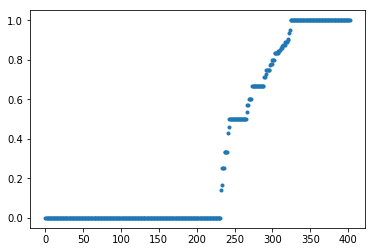

In [27]:
plt.plot(sorted(class_recalls), '.')

In [23]:
classes_small_recall = np.where((class_recalls < 0.501) & (class_recalls > 0.01))
class_small_recalls = class_recalls[classes_small_recall]

In [24]:
len(classes_small_recall[0]), class_small_recalls

(34, array([ 0.49999998,  0.49999999,  0.46153846,  0.33333332,  0.49999998,
         0.49999998,  0.42857142,  0.24999999,  0.14285714,  0.49999998,
         0.49999998,  0.49999998,  0.49999999,  0.49999998,  0.33333332,
         0.49999998,  0.16666666,  0.49999998,  0.49999999,  0.49999998,
         0.49999998,  0.33333332,  0.49999998,  0.33333332,  0.24999999,
         0.49999998,  0.49999998,  0.49999998,  0.24999999,  0.49999998,
         0.49999998,  0.49999998,  0.49999998,  0.49999998]))

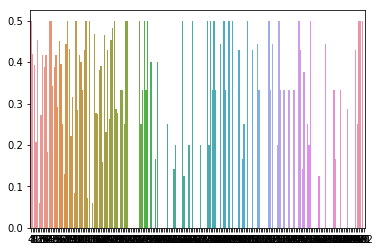

In [39]:
sns.barplot(y=class_small_recalls, x=classes_small_recall[0])

## InceptionResNetV2 model (2nd)

- Image size (451x451)
- TTA

In [28]:
from keras_inceptionResNetV2_finetunning_imbalanced3c4.image_preprocessor import transform, transform_test
from keras_inceptionResNetV2_finetunning_imbalanced3c4.batch_classifier import BatchClassifier, load_pretrained_model

In [29]:
builder = BatchClassifier()
load_pretrained_model(builder.model, logs_path='/home/working_directory/ml/ramp-kits/pollenating_insects_3/logs_inceptionResNetV2_finetunning_imbalanced3c4_2017-10-07-08-51')

Load best loss weights:  /home/working_directory/ml/ramp-kits/pollenating_insects_3/logs_inceptionResNetV2_finetunning_imbalanced3c4_2017-10-07-08-51/weights/InceptionResNetV2_best_val_loss.h5


In [31]:
trained_model = transform, transform_test, builder
folder_X_array, y_train = get_test_data(path="..")

In [32]:
folder_X_array = (folder_X_array[0], folder_X_array[1][:n_samples])

In [33]:
from problem import workflow
workflow.n_jobs = 10
workflow.chunk_size = 256
workflow.test_batch_size = 128

In [34]:
y_proba = workflow.test_submission(trained_model, folder_X_array)

In [35]:
y_true_labels = y_train[:n_samples]
y_pred_labels = np.argmax(y_proba, axis=1)

In [36]:
y_true_labels[:10], y_pred_labels[:10]

(array([ 57,  57,   1, 134, 133,  97, 311, 277,  57,  44]),
 array([ 57,  57,   1, 134, 133,  72, 137,   9,  57,  44]))

In [37]:
res = np.zeros((n_classes, 2), dtype=np.int)

In [38]:
for y_true, y_pred in zip(y_true_labels, y_pred_labels):
    res[y_true, 1] += 1
    if y_true == y_pred:
        res[y_true, 0] += 1

In [39]:
class_recalls = res[:, 0] / (res[:, 1] + 1e-7)

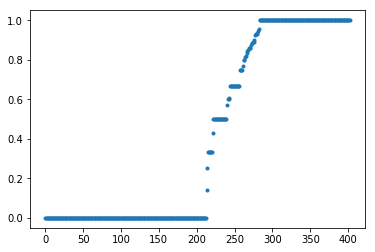

In [40]:
plt.plot(sorted(class_recalls), '.')

In [41]:
classes_small_recall = np.where((class_recalls < 0.501) & (class_recalls > 0.01))
class_small_recalls = class_recalls[classes_small_recall]

In [42]:
len(classes_small_recall[0]), class_small_recalls

(27, array([ 0.49999998,  0.49999999,  0.33333332,  0.49999998,  0.49999998,
         0.49999999,  0.14285714,  0.49999998,  0.49999998,  0.49999998,
         0.49999998,  0.49999998,  0.49999998,  0.33333332,  0.42857142,
         0.49999999,  0.49999998,  0.33333333,  0.33333332,  0.33333332,
         0.49999998,  0.49999999,  0.49999998,  0.33333332,  0.24999999,
         0.49999998,  0.49999998]))

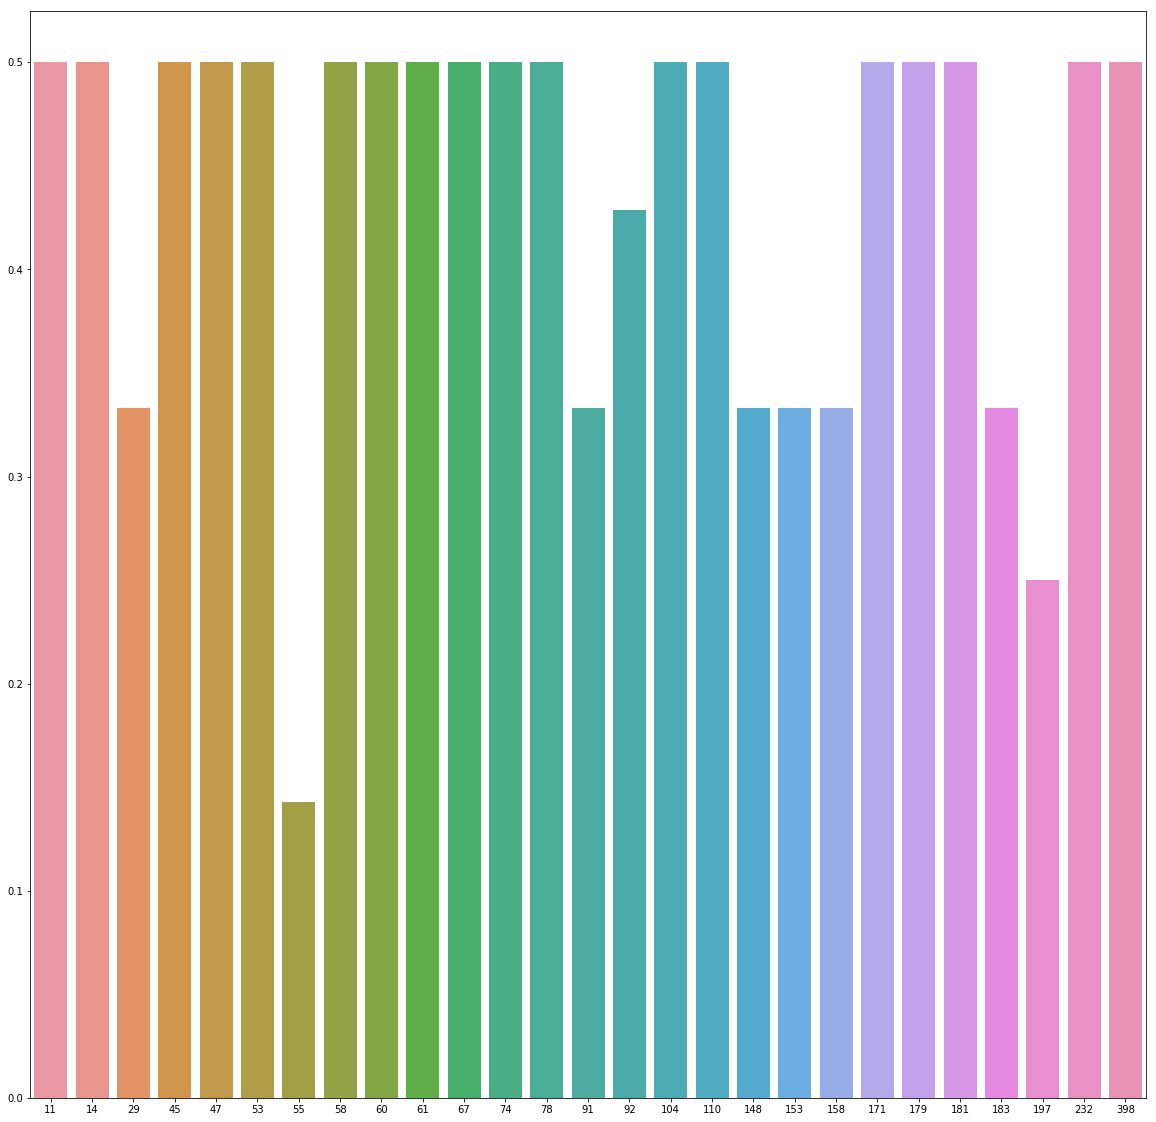

In [43]:
plt.figure(figsize=(20, 20))
sns.barplot(y=class_small_recalls, x=classes_small_recall[0])

In [44]:
print("Classes with small recall: ", classes_small_recall[0])

('Classes with small recall: ', array([ 11,  14,  29,  45,  47,  53,  55,  58,  60,  61,  67,  74,  78,
        91,  92, 104, 110, 148, 153, 158, 171, 179, 181, 183, 197, 232, 398]))


## Estimate small recall classes on validation dataset

In [12]:
from keras_inceptionResNetV2_finetunning_imbalanced4b.image_preprocessor import transform, transform_test
from keras_inceptionResNetV2_finetunning_imbalanced4b.batch_classifier import BatchClassifier, load_pretrained_model
from problem import get_cv, Predictions, score_types, get_test_data, get_train_data

ImportError: cannot import name BatchGeneratorBuilder

In [13]:
from rampwf.workflows.image_classifier import BatchGeneratorBuilder

In [14]:
builder = BatchClassifier()
load_pretrained_model(builder.model, logs_path='/home/working_directory/ml/ramp-kits/pollenating_insects_3/logs_inceptionResNetV2_finetunning_imbalanced4b')

Load best loss weights:  /home/working_directory/ml/ramp-kits/pollenating_insects_3/logs_inceptionResNetV2_finetunning_imbalanced4b/weights/InceptionResNetV2_best_val_loss.h5


In [16]:
batch_size = 64

In [18]:
folder_X_train, y_train = get_train_data(path="..")
cv = list(get_cv(folder_X_train, y_train))

for fold_i, (train_is, valid_is) in enumerate(cv):

    folder, X_train = folder_X_train

    train_gen_builder = BatchGeneratorBuilder(X_array=X_train[train_is], y_array=y_train[train_is], 
                                transform_img=transform, transform_test_img=transform_test, 
                                folder=folder, 
                                chunk_size=batch_size*5, 
                                n_classes=n_classes, n_jobs=1)
    break

In [20]:
from keras_inceptionResNetV2_finetunning_imbalanced4b.batch_classifier import local_get_generator2, \
    local_get_generator, local_get_train_valid_generators, local_get_rare_train_valid_generators

In [21]:
import types

# Try to pickle transform method:
try:
    import pickle
    pickle.dumps(train_gen_builder.transform_img)
    pickle.dumps(train_gen_builder.transform_test_img)
    train_gen_builder._get_generator = types.MethodType(local_get_generator2, train_gen_builder)
except Exception:
    print("Failed to pickle 'transform' function")
    train_gen_builder._get_generator = types.MethodType(local_get_generator, train_gen_builder)

train_gen_builder.get_train_valid_generators = \
    types.MethodType(local_get_train_valid_generators, train_gen_builder)

train_gen_builder.get_rare_train_valid_generators = \
    types.MethodType(local_get_rare_train_valid_generators, train_gen_builder)

train_gen_builder.n_jobs = 8
train_gen_builder.shuffle = True

batch_size = 64
train_gen_builder.chunk_size = batch_size * 8


In [45]:
from tqdm import tqdm_notebook as tqdm
valid_ratio = 0.3

In [46]:
_, gen_valid, _, nb_valid, class_weights = train_gen_builder.get_train_valid_generators(batch_size=batch_size, 
                                                                                        valid_ratio=valid_ratio)

y_valid = np.zeros((nb_valid, 403), dtype=np.int)
y_proba = np.zeros((nb_valid, 403))
count = 0
print("\nEstimate small validation recall classes : ")
with tqdm(total=nb_valid) as pbar:
    for X, y in gen_valid:
        y_valid[count:count + batch_size, :] = y
        y_proba[count:count + batch_size, :] = builder.model.predict(X, batch_size=batch_size)
        pbar.update(batch_size)
        count += batch_size
        if count > nb_valid:
            break


y_true_labels = np.argmax(y_valid, axis=1)
y_pred_labels = np.argmax(y_proba, axis=1)
res = np.zeros((403, 2), dtype=np.int)
for y_true, y_pred in zip(y_true_labels, y_pred_labels):
    res[y_true, 1] += 1
    if y_true == y_pred:
        res[y_true, 0] += 1

class_recalls = res[:, 0] / (res[:, 1] + 1e-7)
classes_small_recall = np.where((class_recalls < 0.701) & (class_recalls > 0.01))[0]

print("\nFound classes: ", classes_small_recall)


Estimate small validation recall classes : 


HBox(children=(IntProgress(value=0, max=14004), HTML(value=u'')))


('\nFound classes: ', array([  9,  10,  16,  17,  21,  32,  34,  49,  51,  55,  60,  65,  66,
        79,  90,  92,  96, 104, 106, 110, 115, 118, 119, 125, 131, 148,
       157, 166, 167, 187, 199, 205, 206, 212, 218, 220, 221, 226, 228,
       237, 239, 240, 242, 245, 247, 255, 258, 264, 268, 269, 270, 271,
       273, 274, 275, 277, 281, 282, 284, 288, 289, 302, 303, 306, 307,
       311, 312, 318, 319, 320, 321, 325, 329, 332, 333, 338, 339, 341,
       343, 346, 348, 349, 354, 355, 359, 365, 366, 367, 368, 369, 370,
       371, 373, 374, 376, 378, 379, 380, 382, 383, 386, 389, 390, 393,
       395, 396, 398, 402]))


In [55]:
a = np.array([  8,  10,  21,  28,  32,  34,  47,  49,  51,  53,  55,  56,  60,
        65,  79,  81,  90,  92, 104, 106, 110, 115, 118, 119, 157, 166,
       167, 174, 177, 181, 187, 192, 199, 205, 206, 213, 214, 217, 221,
       227, 229, 236, 238, 247, 250, 255, 256, 258, 261, 264, 266, 271,
       272, 276, 277, 280, 281, 282, 288, 290, 291, 294, 297, 305, 307,
       310, 315, 322, 331, 337, 339, 340, 342, 346, 348, 352, 353, 354,
       355, 359, 365, 368, 372, 379, 380, 394, 396, 398])

In [57]:
set(a) - set(classes_small_recall)

{8,
 28,
 47,
 53,
 56,
 81,
 174,
 177,
 181,
 192,
 213,
 214,
 217,
 227,
 229,
 236,
 238,
 250,
 256,
 261,
 266,
 272,
 276,
 280,
 290,
 291,
 294,
 297,
 305,
 310,
 315,
 322,
 331,
 337,
 340,
 342,
 352,
 353,
 372,
 394}

In [56]:
{1,2,3} - {1,2,3,4,5}

set()

In [2]:
import numpy as np

In [3]:
a = np.array([  8,  10,  21,  28,  32,  34,  47,  49,  51,  53,  55,  56,  60,
        65,  79,  81,  90,  92, 104, 106, 110, 115, 118, 119, 157, 166,
       167, 174, 177, 181, 187, 192, 199, 205, 206, 213, 214, 217, 221,
       227, 229, 236, 238, 247, 250, 255, 256, 258, 261, 264, 266, 271,
       272, 276, 277, 280, 281, 282, 288, 290, 291, 294, 297, 305, 307,
       310, 315, 322, 331, 337, 339, 340, 342, 346, 348, 352, 353, 354,
       355, 359, 365, 368, 372, 379, 380, 394, 396, 398])

In [4]:
b = np.array([  9,  10,  16,  17,  21,  32,  34,  49,  51,  55,  60,  65,  66,
        79,  90,  92,  96, 104, 106, 110, 115, 118, 119, 125, 131, 148,
       157, 166, 167, 187, 199, 205, 206, 212, 218, 220, 221, 226, 228,
       237, 239, 240, 242, 245, 247, 255, 258, 264, 268, 269, 270, 271,
       273, 274, 275, 277, 281, 282, 284, 288, 289, 302, 303, 306, 307,
       311, 312, 318, 319, 320, 321, 325, 329, 332, 333, 338, 339, 341,
       343, 346, 348, 349, 354, 355, 359, 365, 366, 367, 368, 369, 370,
       371, 373, 374, 376, 378, 379, 380, 382, 383, 386, 389, 390, 393,
       395, 396, 398, 402])

In [7]:
len(set(a) ^ set(b))

100

In [9]:
np.array(list(set(a) ^ set(b)))

array([256, 261,   9, 266, 268, 269, 270,  16,  17, 274, 275, 276, 280,
        47, 284, 289, 290, 291, 294, 302, 303, 305, 306,  53, 310, 312,
       315, 318, 319, 320, 352,  66, 325, 353, 329, 311, 332, 333,  56,
       338, 340, 341, 342, 343, 349,  96, 272, 273, 367, 369, 370, 372,
       373, 376, 378, 125, 382, 386, 131, 389, 390, 321, 393, 394, 395,
       322, 402, 148, 366,  81,  28, 174, 177, 371, 181, 192, 331, 374,
       212, 213, 214, 217, 218, 220, 226, 227, 228, 229, 337, 236, 237,
       238, 239, 240, 242, 245,   8, 297, 250, 383])